## Quantify similarity/divergence of human vs model=f(prompt)

Goal of Waerme und Wohnen Panel: understand the drivers and constraints for renovations to increase energy efficiency in Germany per socio-economic/demographic profile 
Goal of the thesis research: 
1. Reproduce hunan drivers/constraints for renovations in order to use the method for potential future pilot studies
2. If not possible to reproduce results identify and quantify the biases as well as potential solutions

### 1. Evaluate model decisions

The method aims to support pilot studies for policy design in the field of building decarbonization. 
From the three market failures presented in Singhal 2023:
* Externalities
    * What is the effect of internalizing the externality of CO2 emissions by carbon prices?
    * What is the effect of high volatility fossil fuel prices (high risk)
* Principal-Agent probelm
    * What is the effect of tenant/owner distribution of externalities and renovation costs
* **Credit Constraints**
    * **From those receiving subsidies, who are free raiders?** --> Always choose option B
    * **From those that do not perform a renovation, is it a budget constraint blocker? Who are them?** 
        * Hard limitations: Those that would only make the decision of complex renovation until 200 euros difference with simple (option 5)
        * Middle limitations: Those that would make the decision of complex renovation from 250-450 euros difference with simple (option 6-10) 
        * Mild limitations: Those that would make the decision of complex renovation from 500-900 euros difference with simple (option 11-14) 
    * What kind of errors will have a high penalty in policy design?
        * Consider free-raiders as price elastic citizens --> Diminish free-raider false negatives (recall): those that are predicted as something else but are free raiders so will get funding when they should not
        * Consider price elastic citizens as never-takers --> Diminish never-takers false negatives (recall): those that are predicted as compliers when are never-takers so have access to funding that wont be used

### 2. Quantify Bias
1. Do the models reproduce the human decisions? NO
    * Confusion matrix metrics
2. Which factors explain the error?
    * Option A) Fit a log regression with relevant factors to understand what drives decisions in humans vs model=f(prompt)
    * Option B) Model the error difference between the human and GPT-4
    * Option C) Model the difference between the decision taken and the rational decision according to object financial benefits
        * Calculate the optimal decision according to a) costs of renovation, b) savings per renovation and c) the expected years living in the flat
        * Compare bias/error from rational decion between human and GPT-4
        * Compare bias/error between different GPT-4 prompts (and GPT-3.5)
3. Is the error different depending on the type of prompt or is it consistent so it depends on the model?
4. Is the error symmetric or asymmetric?

**Which kind of information do I need for option C?**
* Option C) What determines if a person makes rational or emotional decisions?
    * Education level --> affect the next ones
    * Life ownership
    * Nature conservation concern
    * Belief in energy efficiency
    * Political orientation
    * Income and wealth level --> affect the next one
    * Long-term profit oriented
* Option C) How do I define rational behavior?
    * The savings in energy over the planned years (case -2% price increase or worse case scenario) - renovation costs ==> Highest profit option at each question
    * Market value variation --> purchase according to the DIW study 
    * Fix values per individual
        * savings per renovation type x years in the house
        * market value variation per renovation type
        * renovation costs of simple renovation
    * Variable values per individual
        * Net Present Value (PAPER MIT) = Gain Market Value + savings=f(discount rate, years) - Renovation Costs
        * Gain Market Value (DIW report) =  β × (EPSoriginal − EPS) where β = 0.71 EUR/m2 for purchasing and 0.002 EUR/m2 for renting
    * Calculate rational decision according to the previous calculations
        * Keep the information of difference on NPV
        * Keep the information of difference on Renovation costs
        * Keep the information of where the transition between complex and simple should happen, if at all, from a rational perspective
        * Keep the information of where the transition between complex and simple happen, if at all, by the human and the algorithm
        * Calculate where should be the transition from complex to simple if any to maximize NPV in each decision
    * Regression on the decision
        * Quantify the difference between the optimal rational transition, if any, and the human/algorithm
            * Difference in NPV
            * Difference in renovation cost
        * Every decision could be attributed the 0/1 value for matching rational decision or not --> does not capture asymmetric behavior
        * Every decision could be attributed the actual difference on NPV between the rational option and the decision made --> does capture asymmetric behavior
            * Requires panel data analysis
        * One decision per individual rather than per question --> Difference between the optimal transition point by rational agent vs human/algorithm in terms of NPV diff
            * Does not require panel data analysis
        * Factors
            * Prostpect theory: loss adversion/risk preference
                * Long term benefit
                * Life handling
                * Altruism
                * Beliefs on energy efficiency
            * Socioeconomic factors
                * Political orientation
                * Income level/wealth level
                * Education level
                * Building type

In [1]:
import sys
sys.path.append("../../../")

import numpy as np
import pandas as pd

from scipy.stats import norm

from src.eval_utils.metric_calculator import ResultEvaluator, plot_class_recalls, plot_recall
from src.eval_utils.utility_calculator import DeltaNVP

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

### 1. Load results

In [60]:
final_columns = ['ea801', 'ea802', 'ea803', 'ea804', 'ea805', 'ea806', 'ea807', 'ea808', 'ea809', 'ea810', 'ea811', 
                 'ea812', 'ea813', 'ea814', 'ea815']
opportunity_cost = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 900, 1200]
# Generate dataframe for evaluation
socioeconomic_factors = ['total_income_level','is_high_wealth','high_education_level','altq','prof_status']
psychological_factors = ['pol_orientation','is_altruist','nature_level','ownership_level','profit_focus','ee_belief']
npv_factors = ['ist5','kdj','kde','kdu','ebj','ebe','ebu','a6']
columns_to_exclude_ols = ['success', 'label', 'temperature', 'decision', 'key', 
                      'citizen_type', 'profit_focus_long', 'profit_focus_short', 
                      'ownership_level_Medium', 'ownership_level_High', 
                      'nature_level_High', 'nature_level_Medium', 
                      'pol_orientation_left', 'pol_orientation_right', 
                      'pol_orientation_center', 'is_altruist']

df_sample = pd.read_csv("../../../data/ariadne/heating_buildings/df_c1t1_completed_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')
df_questions = pd.read_csv("../../../data/ariadne/heating_buildings/questions_selected_survey_mapper_encoded.csv", sep=';', encoding='utf-8', on_bad_lines='skip')
df_sel_complete_pol_ta_clean = pd.read_csv("../../../data/ariadne/heating_buildings/df_c1t1_sample_100_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')

# 2. GPT-4 emotional - Ta: 0.1
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240108_0647/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
output_file2 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_0924/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
df_synthetic_samples1 = pd.read_csv(output_file)
df_synthetic_samples2 = pd.read_csv(output_file2)
df_synthetic_4_emotional_0_1 = pd.concat([df_synthetic_samples1, df_synthetic_samples2])

# 2. GPT-3.5 emotional - Ta: 0.1
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240108_0638/recurrent_gpt-3.5-turbo-1106-t_0.1_qa.csv'
df_synthetic_3_5_emotional_0_1 = pd.read_csv(output_file)

### 2. Calculate model performance by prompt strategy and temperature

#### 2.1. Calculate confusion matrices

In [61]:
df_sample.citizen_type.unique()

array(['free rider', 'complier', 'unknown', 'defier', 'never taker'],
      dtype=object)

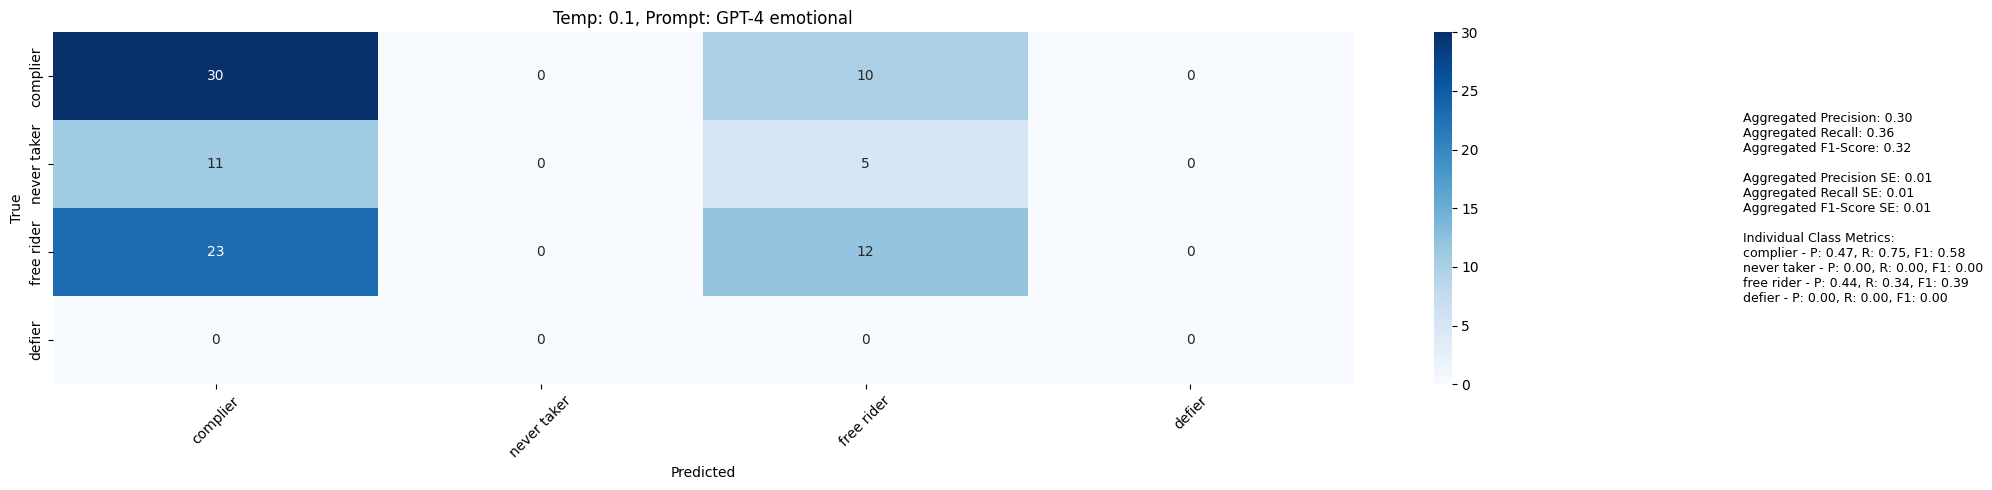

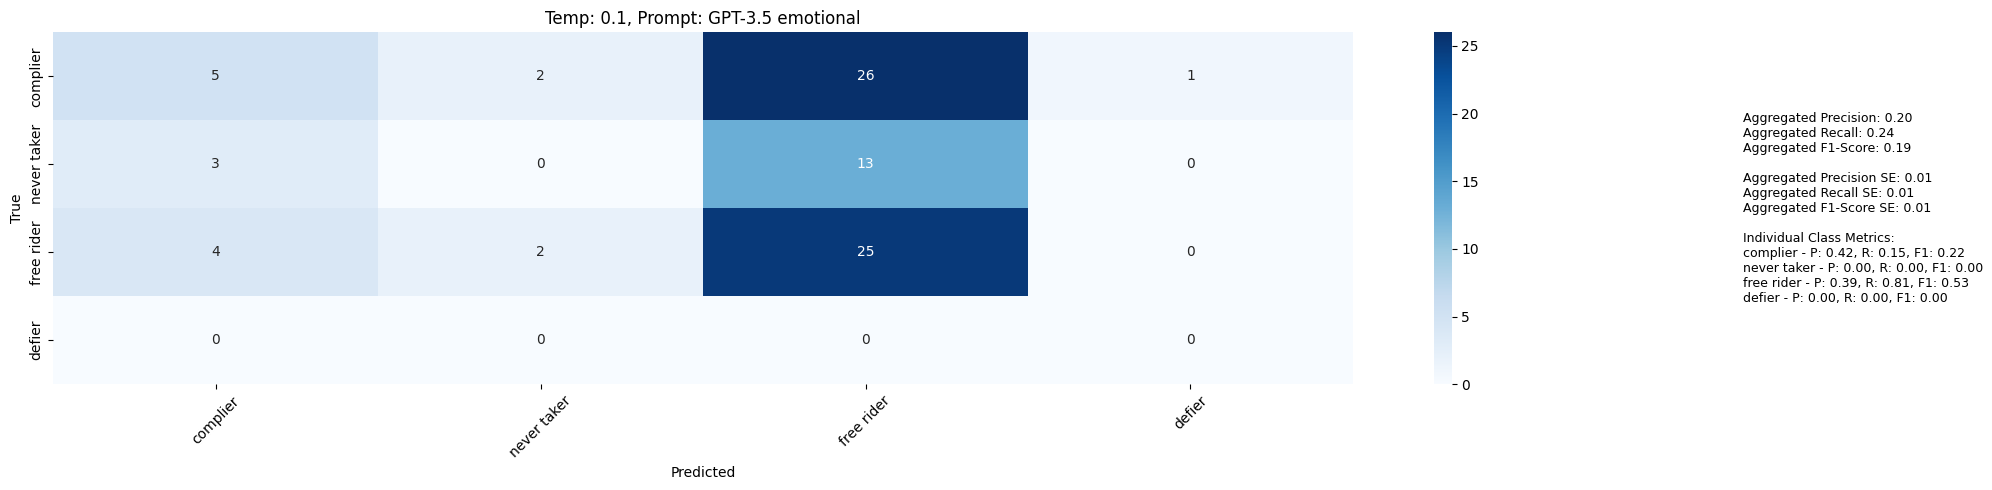

In [62]:
metrics = []
n_bootstraps = 5
evaluator = ResultEvaluator(final_columns=final_columns, opportunity_costs=opportunity_cost)
df_metrics, df_sample_sel_4_emotional, df_synthetic_4_emotional = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_4_emotional_0_1], 
                                ['complier','never taker', 'free rider','defier'], [0.1], 'GPT-4 emotional', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)
df_metrics, df_sample_sel_3_5_emotional, df_synthetic_3_5_emotional = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_3_5_emotional_0_1], 
                                ['complier','never taker', 'free rider','defier'], [0.1], 'GPT-3.5 emotional', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

#### 2.1. Calculate bootstrapped recall for key classes

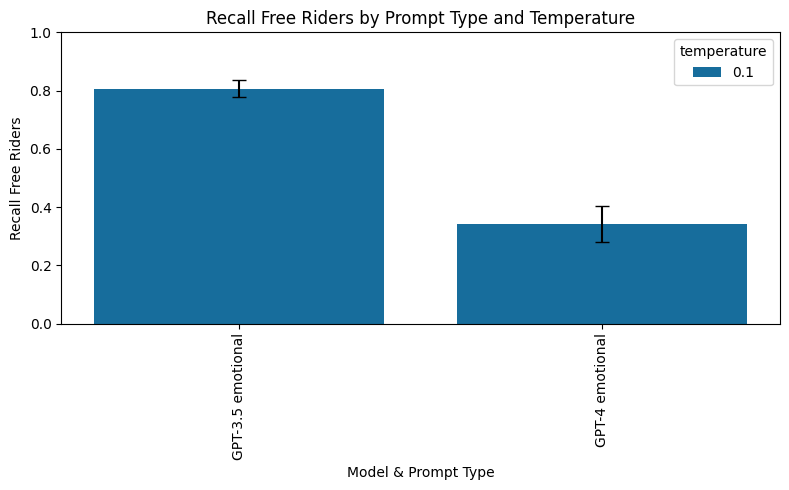

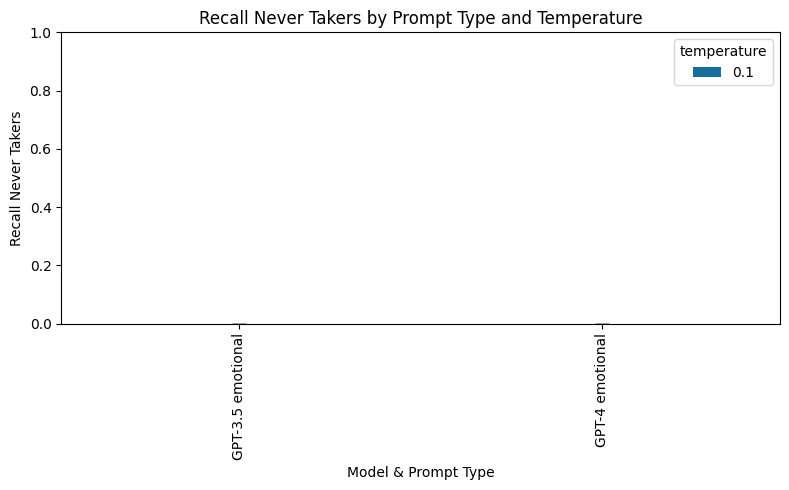

In [57]:
df_metrics = pd.concat(metrics)
df_ = plot_class_recalls(df_metrics)
plot_recall(df_, recall_type='recall_free_riders')
plot_recall(df_, recall_type='recall_never_takers')

### 3. Compare Objective vs Subjective Utilities per Model/Prompt/Temperature

Human:
#['is_psychologically_capable_opp_cost_interaction','ee_belief_opp_cost_interaction','is_nature_protector_opp_cost_interaction','is_short_term_profit_opp_cost_interaction',###'is_nature_protector','is_short_term_profit','is_psychologically_capable','']
GPT-4:
#['is_psychologically_capable_opp_cost_interaction','ee_belief_opp_cost_interaction','is_nature_protector_opp_cost_interaction','is_nature_protector'
###'is_short_term_profit','is_psychologically_capable','is_short_term_profit_opp_cost_interaction','is_short_term_profit']
GPT-3.5:
#['is_psychologically_capable_opp_cost_interaction','ee_belief_opp_cost_interaction','is_nature_protector_opp_cost_interaction','is_nature_protector'
###'is_short_term_profit','is_psychologically_capable','is_short_term_profit_opp_cost_interaction','is_short_term_profit']

#### 3.1. Human Objective vs Subjective utility

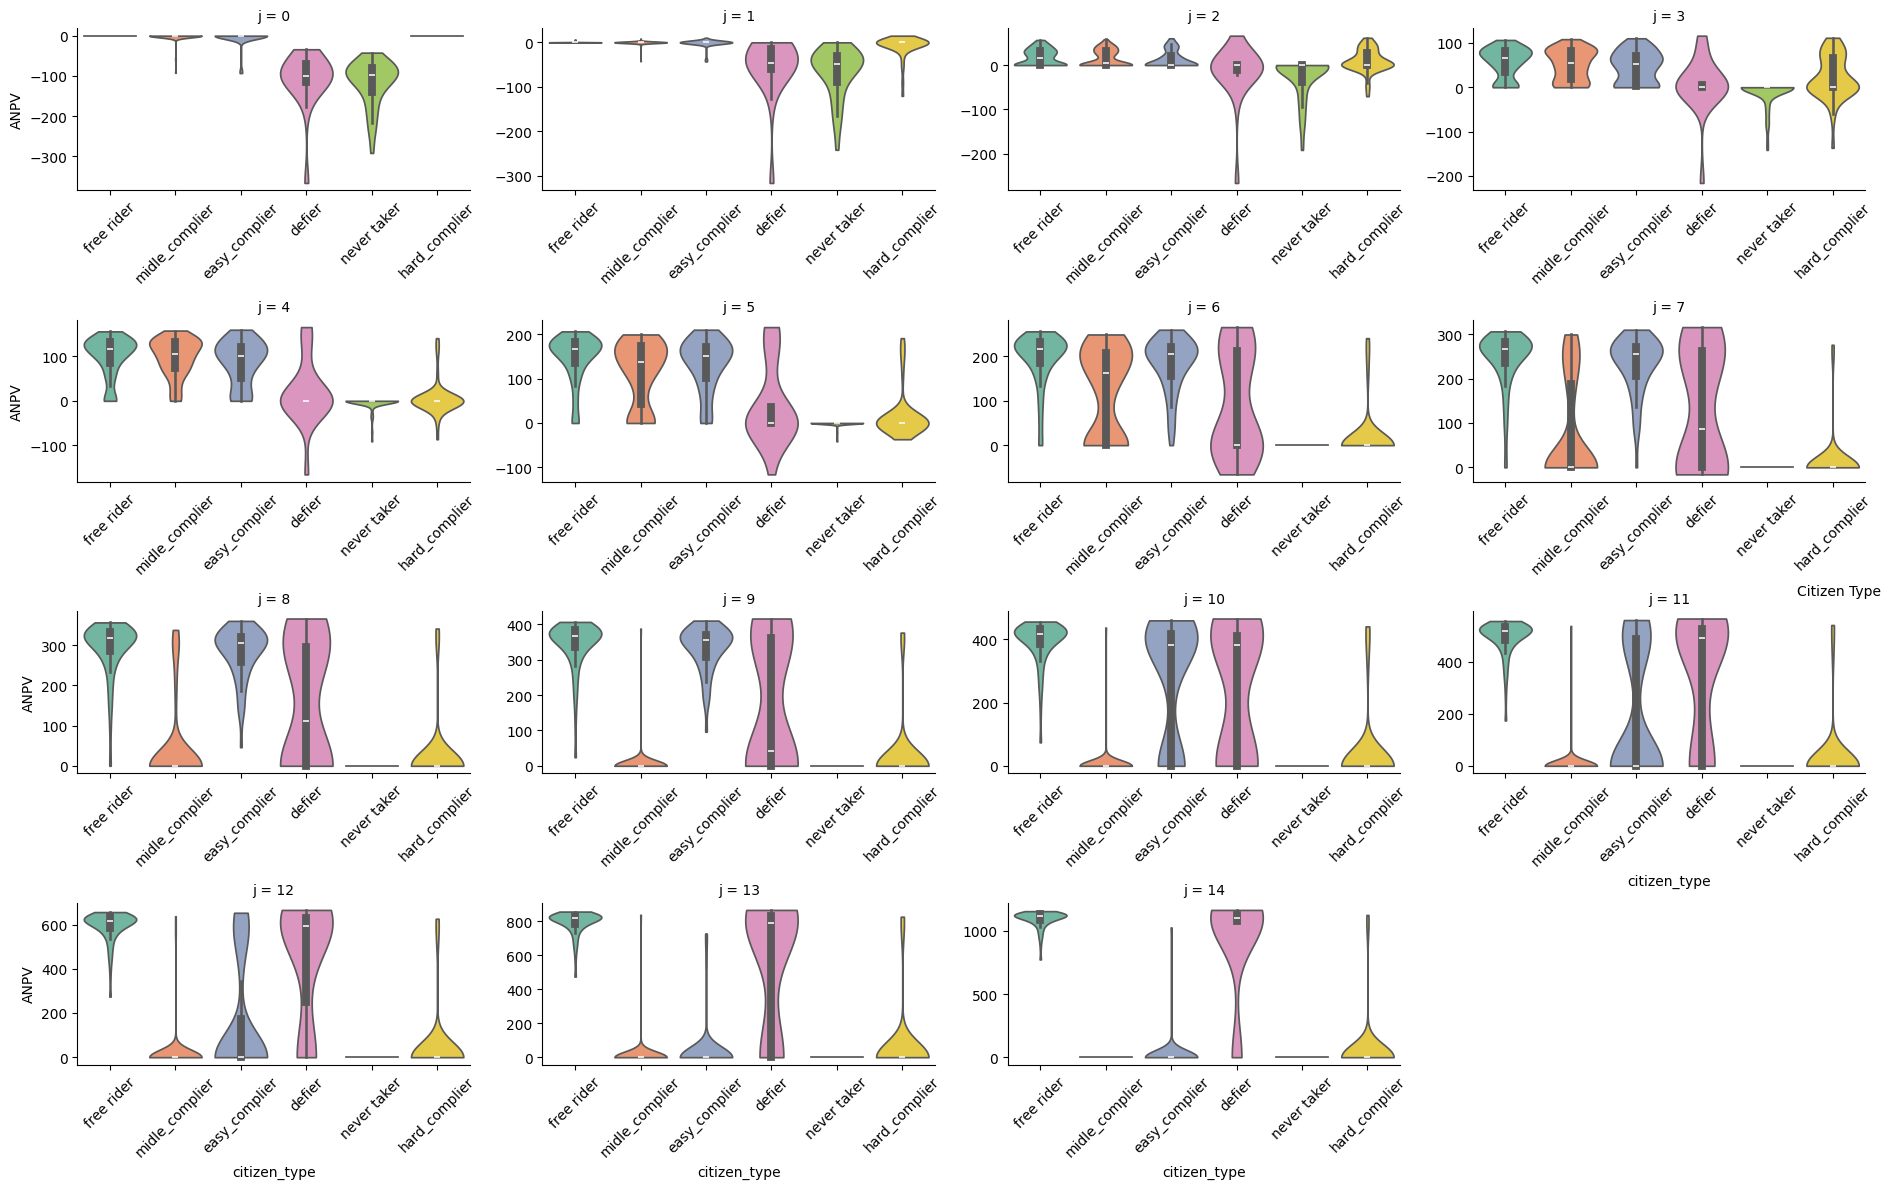

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     421.0
Date:                Mon, 08 Jan 2024   Prob (F-statistic):          1.28e-322
Time:                        19:23:09   Log-Likelihood:                -8361.3
No. Observations:                6420   AIC:                         1.673e+04
Df Residuals:                    6415   BIC:                         1.677e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [25]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
calculator = DeltaNVP(discount_rate=1.128)
df_relevant = df_sample[df_sample['citizen_type']!='unknown']
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
independent_variables = ['is_nature_protector']
summary, df_merged_human = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)

#### 3.2. GPT-4 + Emotional prompt + Temp 0.1: Objective vs Subjective utility

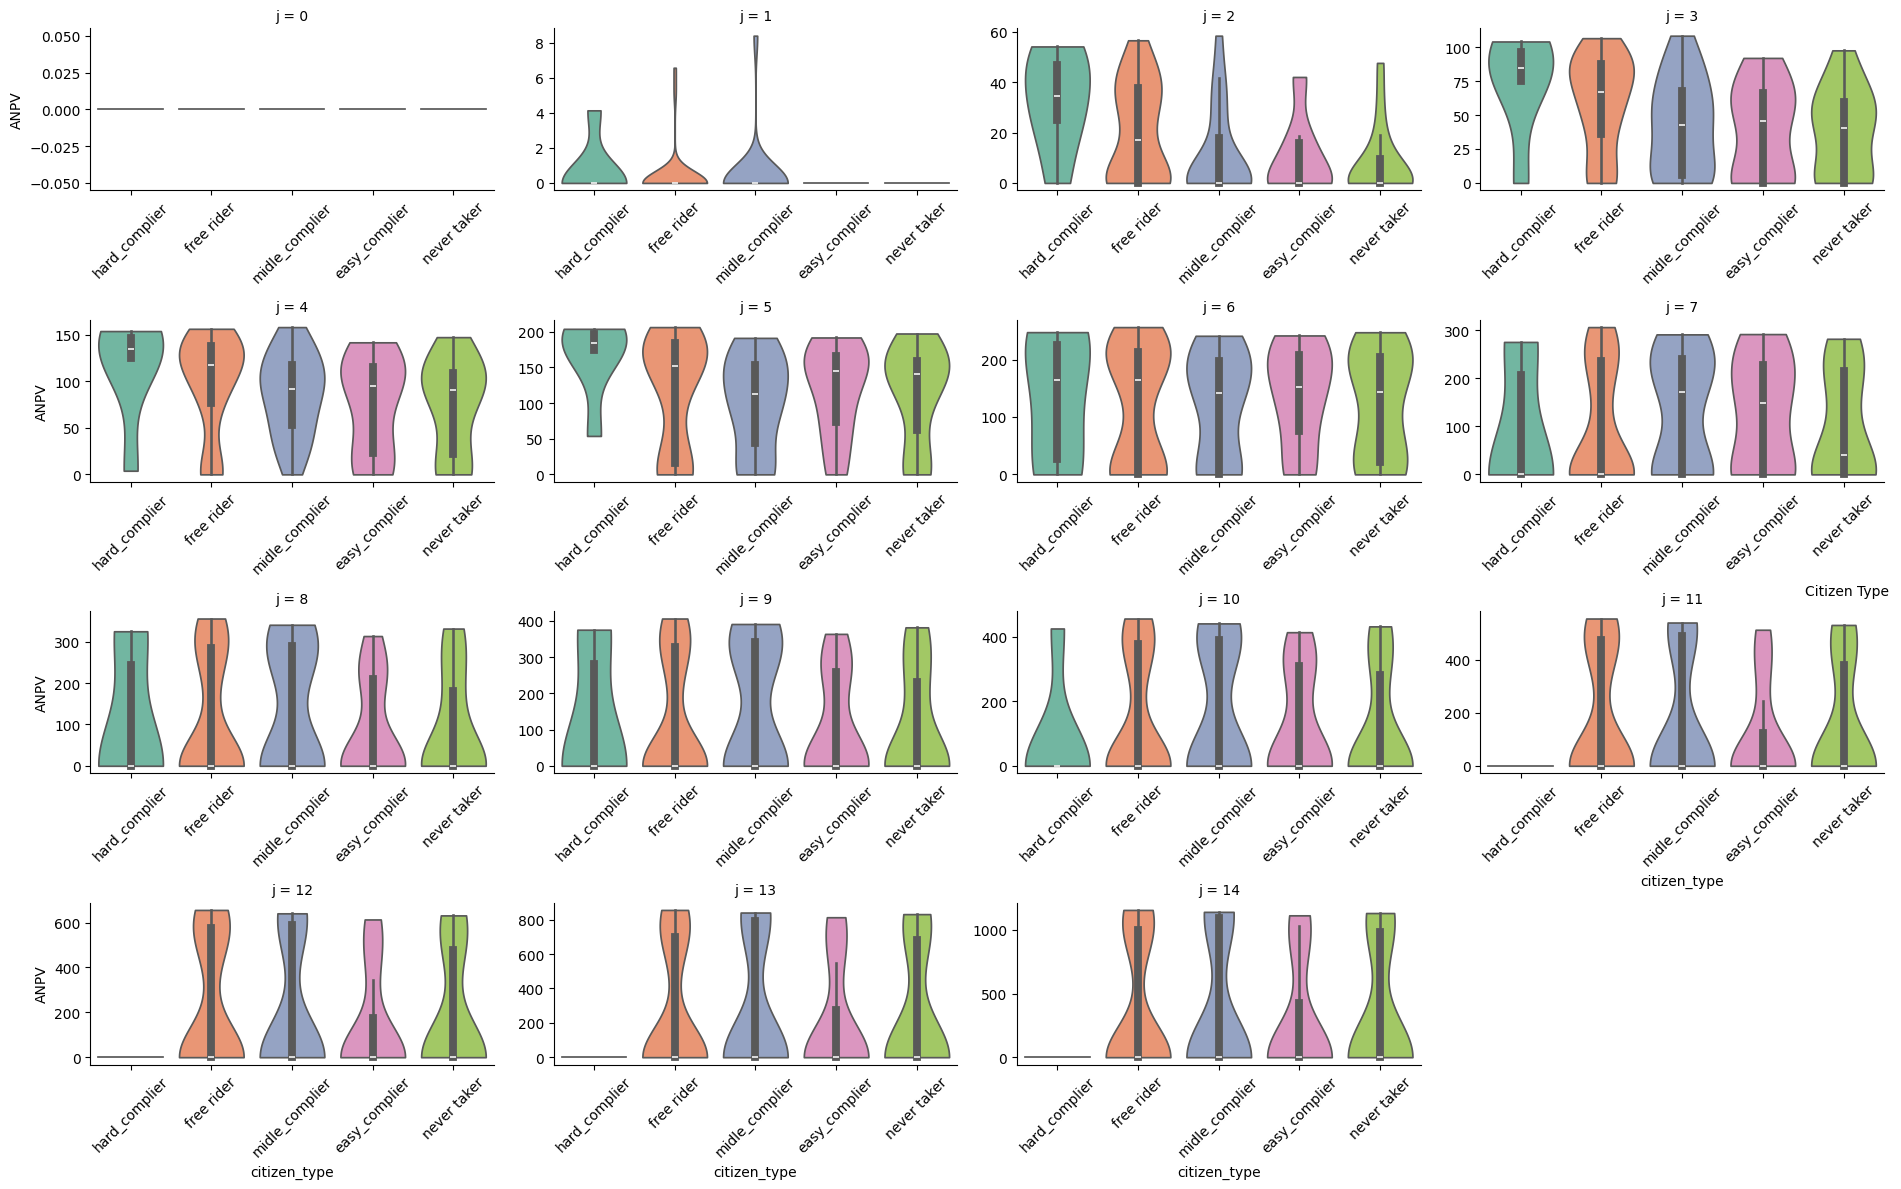

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     64.51
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           5.44e-50
Time:                        19:23:20   Log-Likelihood:                -1818.3
No. Observations:                1365   AIC:                             3647.
Df Residuals:                    1360   BIC:                             3673.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [26]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_4_emotional_0_1['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_4_emotional_0_1[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_gpt4_01 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


#### 3.6. GPT-3.5-turbo + Emotional prompt + Temp 0.1: Objective vs Subjective utility

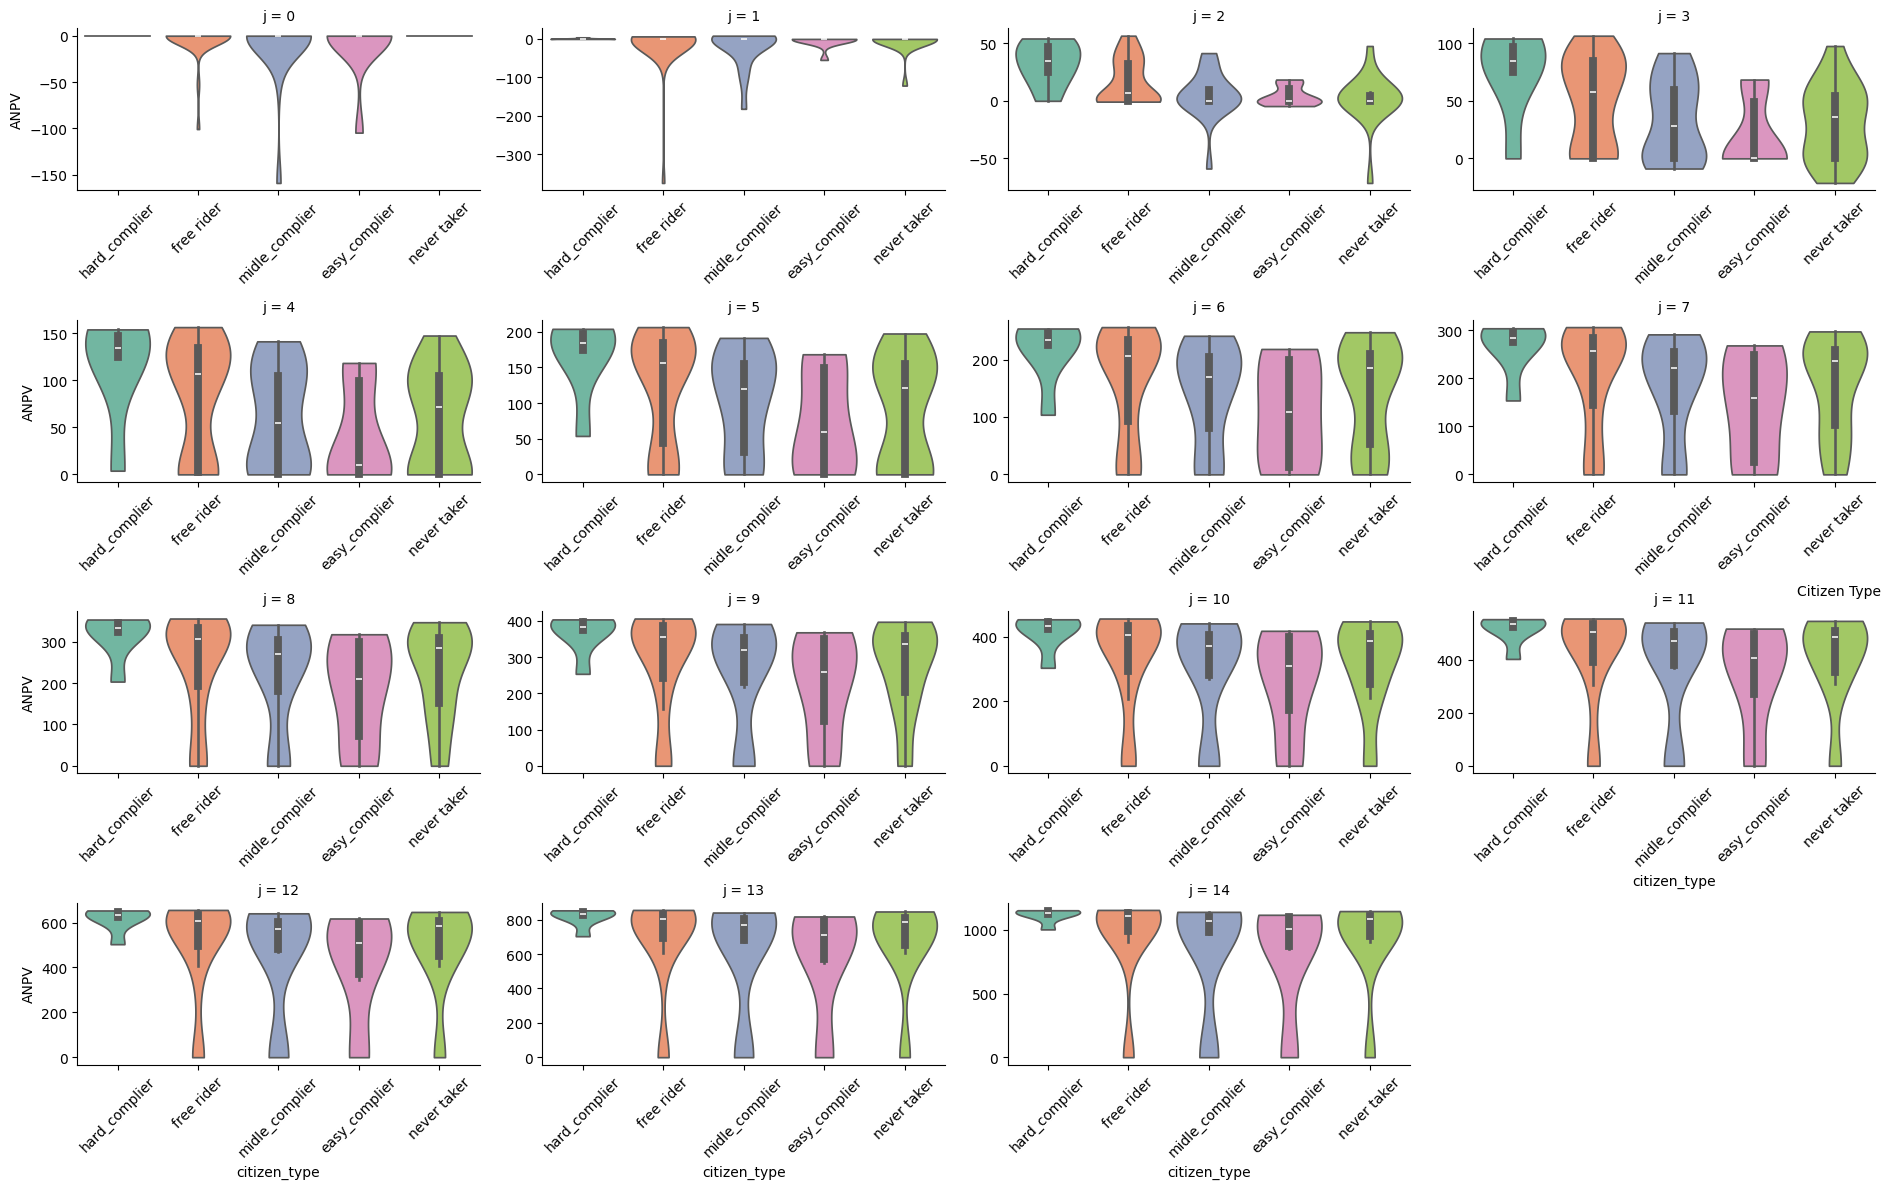

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     747.6
Date:                Mon, 08 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:23:29   Log-Likelihood:                -967.96
No. Observations:                1215   AIC:                             1946.
Df Residuals:                    1210   BIC:                             1971.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [27]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_3_5_emotional_0_1['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_3_5_emotional_0_1[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_gpt35_01 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


### Visualization of probabilities

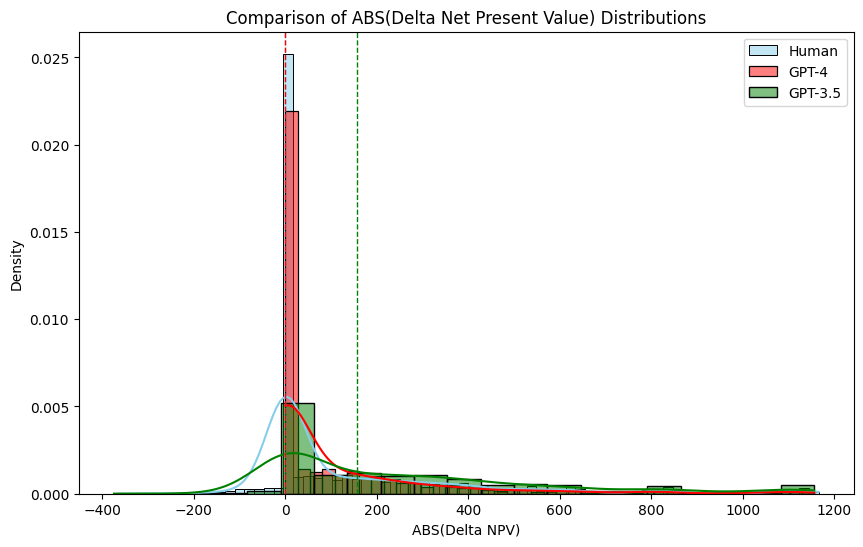

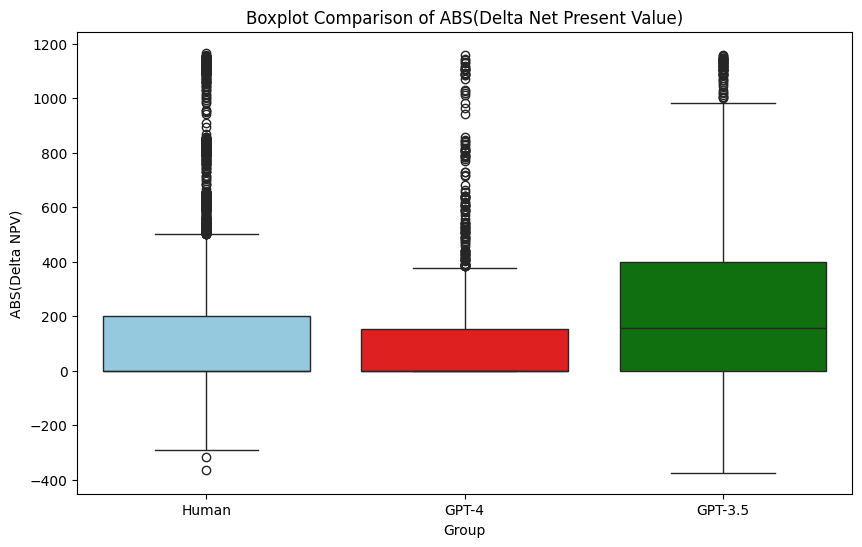

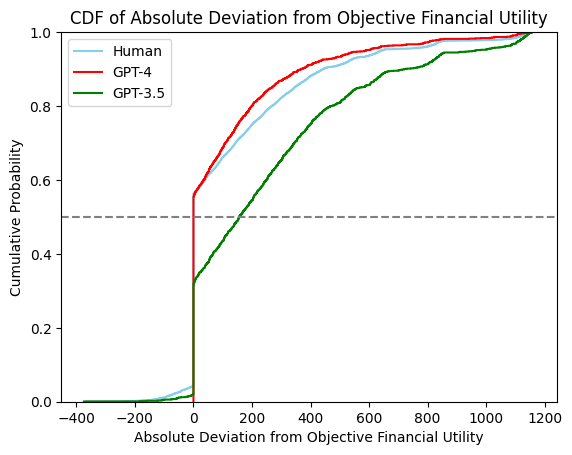

In [28]:
# Are humans more likely to deviate from the objective financial solution?
# HISTOGRAM
plt.figure(figsize=(10, 6))

# Use transparency and different colors for better visibility
sns.histplot(df_merged_human['ANPV'], color="skyblue", label='Human', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_gpt4_01['ANPV'], color="red", label='GPT-4', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_gpt35_01['ANPV'], color="green", label='GPT-3.5', kde=True, stat="density", alpha=0.5)

# Add mean lines for each distribution
plt.axvline(df_merged_human['ANPV'].median(), color="skyblue", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_gpt4_01['ANPV'].median(), color="red", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_gpt35_01['ANPV'].median(), color="green", linestyle='dashed', linewidth=1)

# Add legend and labels
plt.legend()
plt.xlabel('ABS(Delta NPV)')
plt.ylabel('Density')
plt.title('Comparison of ABS(Delta Net Present Value) Distributions')
plt.show()

# BOXPLOT
# Combine the data into a single DataFrame for plotting
df_merged_human_reset = df_merged_human.reset_index(drop=True)
merged_df_gpt4_01_reset = merged_df_gpt4_01.reset_index(drop=True)
merged_df_gpt35_01_reset = merged_df_gpt35_01.reset_index(drop=True)

# Combine the data into a single DataFrame for plotting
data_to_plot = pd.concat([df_merged_human_reset['ANPV'], 
                          merged_df_gpt4_01_reset['ANPV'], 
                          merged_df_gpt35_01_reset['ANPV']], 
                         axis=1, 
                         keys=['Human', 'GPT-4', 'GPT-3.5'])

# Melt the data for seaborn boxplot
data_long_form = data_to_plot.melt(var_name='Group', value_name='ANPV')

# Define specific colors for each group
group_colors = {"Human": "skyblue", "GPT-4": "red", "GPT-3.5": "green"}

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_long_form, x='Group', y='ANPV', palette=group_colors)
plt.xlabel('Group')
plt.ylabel('ABS(Delta NPV)')
plt.title('Boxplot Comparison of ABS(Delta Net Present Value)')
plt.show()

# CALCULATE CDF
# Plot the CDFs
sns.ecdfplot(df_merged_human['ANPV'], label='Human', color="skyblue")
sns.ecdfplot(merged_df_gpt4_01['ANPV'], label='GPT-4', color="red")
sns.ecdfplot(merged_df_gpt35_01['ANPV'], label='GPT-3.5', color="green")

# Add reference lines if needed (e.g., median or specific percentile)
plt.axhline(y=0.5, color='gray', linestyle='--')  # Example for median

plt.xlabel('Absolute Deviation from Objective Financial Utility')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Absolute Deviation from Objective Financial Utility')
plt.legend()
plt.show()

**Observations**
* Models tend to be overall more risk takers as well as human.
* GPT-4 is closer to the Objective Financial Utility. However, it can not reproduce risk adverse human behavior.
* GPT-3.5 is the most optimistic model with the largest error towards risk taker as well as the largest (wider) distribution.

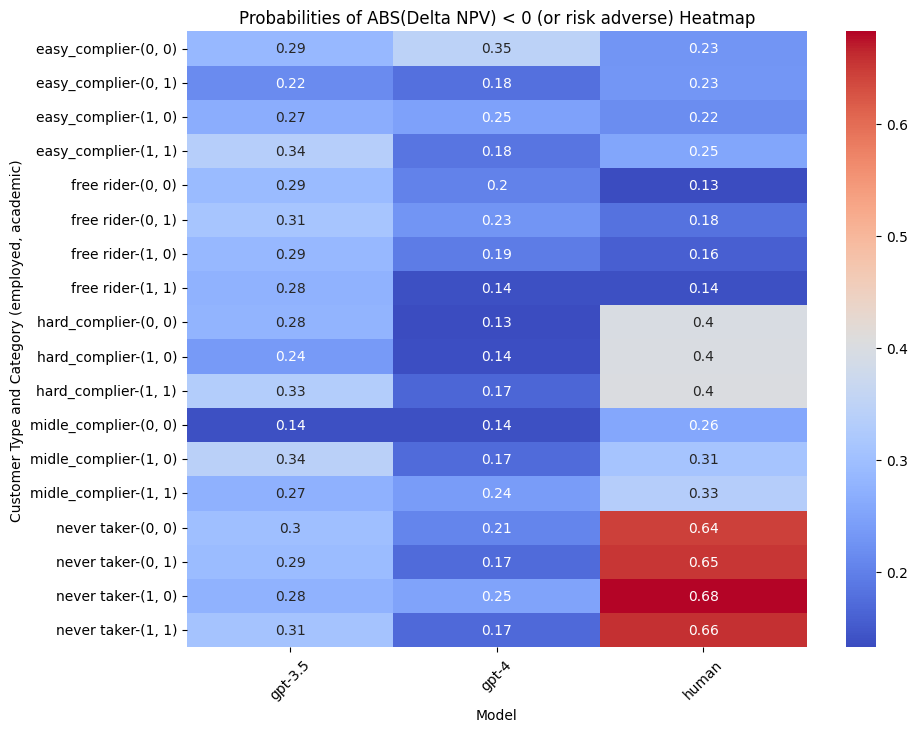

In [50]:
def calculate_conditional_probabilities(data, metric, category1, category2, value):
    results = {}
    for cat1 in data[category1].unique():
        for cat2 in data[category2].unique():
            subset = data[(data[category1] == cat1) & (data[category2] == cat2)]
            mean, std = subset[metric].mean(), subset[metric].std()

            # Assuming a normal distribution, modify as needed
            prob_distribution = norm(mean, std)

            # Example: Probability of metric being less than a specific value
            prob = prob_distribution.cdf(value)  # Change 0 to your specific value
            results[(cat1, cat2)] = prob

    return results

# CALCULATION OF PROBABILITIES
# Calculate probabilities for each group
df_merged_human['is_employed'] = np.where(df_merged_human['prof_status']=='employed', 1, 0)
merged_df_gpt4_01['is_employed'] = np.where(merged_df_gpt4_01['prof_status']=='employed', 1, 0)
merged_df_gpt35_01['is_employed'] = np.where(merged_df_gpt35_01['prof_status']=='employed', 1, 0)
df_merged_human['is_academic'] = np.where(df_merged_human['high_education_level']=='academic', 1, 0)
merged_df_gpt4_01['is_academic'] = np.where(merged_df_gpt4_01['high_education_level']=='academic', 1, 0)
merged_df_gpt35_01['is_academic'] = np.where(merged_df_gpt35_01['high_education_level']=='academic', 1, 0)
df_merged_human_ = df_merged_human.reset_index()
merged_df_gpt4_01_ = merged_df_gpt4_01.reset_index()
merged_df_gpt35_01_ = merged_df_gpt35_01.reset_index()

probabilities = []
citizen_types = ['hard_complier', 'easy_complier', 'midle_complier','never taker', 'free rider','defier']
for type in citizen_types:
    key_ids = merged_df_gpt35_01_[merged_df_gpt35_01_['citizen_type']==type]['key'].unique().tolist()
    conditional_probs_human = calculate_conditional_probabilities(df_merged_human_[df_merged_human_['key'].isin(key_ids)], 'ANPV', 'is_employed', 'is_academic',0)
    conditional_probs_gpt35 = calculate_conditional_probabilities(merged_df_gpt4_01_[merged_df_gpt4_01_['key'].isin(key_ids)], 'ANPV', 'is_employed', 'is_academic',0)
    conditional_probs_gpt4 = calculate_conditional_probabilities(merged_df_gpt35_01_[merged_df_gpt35_01_['key'].isin(key_ids)], 'ANPV', 'is_employed', 'is_academic',0)

    # Flatten the structure
    for category, prob in conditional_probs_human.items():
        probabilities.append({'type': type, 'model': 'human', 'category (employed, academic)': category, 'probability': prob})
    
    for category, prob in conditional_probs_gpt35.items():
        probabilities.append({'type': type, 'model': 'gpt-3.5', 'category (employed, academic)': category, 'probability': prob})

    for category, prob in conditional_probs_gpt4.items():
        probabilities.append({'type': type, 'model': 'gpt-4', 'category (employed, academic)': category, 'probability': prob})

df_probs = pd.DataFrame(probabilities)

heatmap_data = df_probs.pivot_table(index=['type', 'category (employed, academic)'], columns='model', values='probability')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Probabilities of ABS(Delta NPV) < 0 (or risk adverse) Heatmap')
plt.ylabel('Customer Type and Category (employed, academic)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

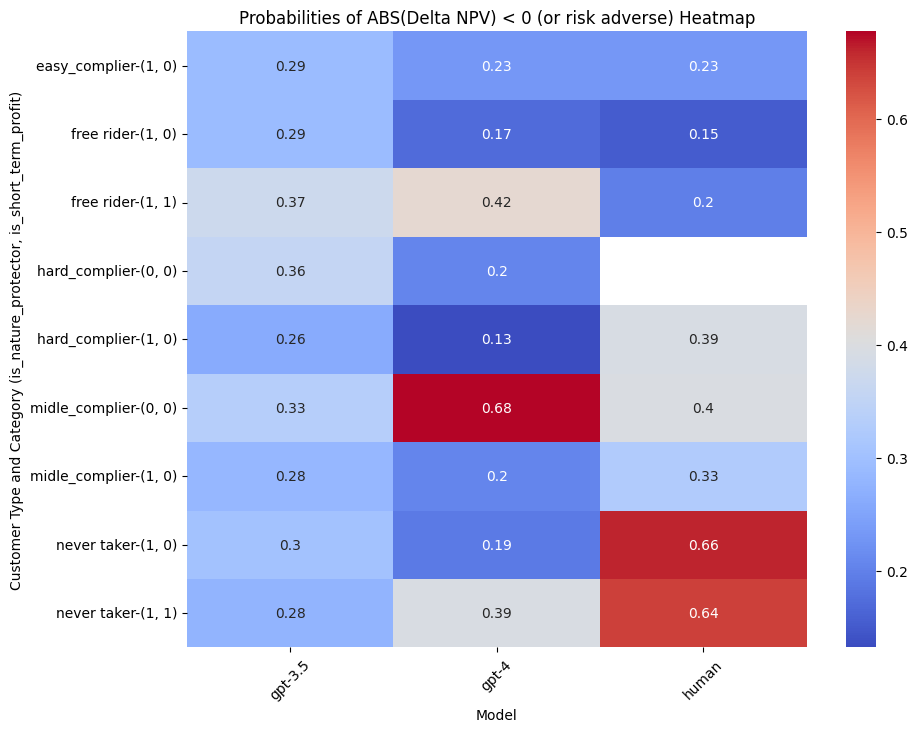

In [54]:
# CALCULATION OF PROBABILITIES
# Calculate probabilities for each group
df_merged_human_ = df_merged_human.reset_index()
merged_df_gpt4_01_ = merged_df_gpt4_01.reset_index()
merged_df_gpt35_01_ = merged_df_gpt35_01.reset_index()

probabilities_psyco = []
citizen_types = ['hard_complier', 'easy_complier', 'midle_complier','never taker', 'free rider','defier']
for type in citizen_types:
    key_ids = merged_df_gpt35_01_[merged_df_gpt35_01_['citizen_type']==type]['key'].unique().tolist()
    conditional_probs_human = calculate_conditional_probabilities(df_merged_human_[df_merged_human_['key'].isin(key_ids)], 'ANPV', 'is_nature_protector', 'is_short_term_profit',0)
    conditional_probs_gpt35 = calculate_conditional_probabilities(merged_df_gpt4_01_[merged_df_gpt4_01_['key'].isin(key_ids)], 'ANPV', 'is_nature_protector', 'is_short_term_profit',0)
    conditional_probs_gpt4 = calculate_conditional_probabilities(merged_df_gpt35_01_[merged_df_gpt35_01_['key'].isin(key_ids)], 'ANPV', 'is_nature_protector', 'is_short_term_profit',0)

    # Flatten the structure
    for category, prob in conditional_probs_human.items():
        probabilities_psyco.append({'type': type, 'model': 'human', 'category (is_nature_protector, is_short_term_profit)': category, 'probability': prob})
    
    for category, prob in conditional_probs_gpt35.items():
        probabilities_psyco.append({'type': type, 'model': 'gpt-3.5', 'category (is_nature_protector, is_short_term_profit)': category, 'probability': prob})

    for category, prob in conditional_probs_gpt4.items():
        probabilities_psyco.append({'type': type, 'model': 'gpt-4', 'category (is_nature_protector, is_short_term_profit)': category, 'probability': prob})

df_probs_psyco = pd.DataFrame(probabilities_psyco)

heatmap_data = df_probs_psyco.pivot_table(index=['type', 'category (is_nature_protector, is_short_term_profit)'], columns='model', values='probability')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Probabilities of ABS(Delta NPV) < 0 (or risk adverse) Heatmap')
plt.ylabel('Customer Type and Category (is_nature_protector, is_short_term_profit)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

**Observations**:
* One of the hardest parts to reproduce by the models was the balance between nature respect and long-term profit perspective. Here we see that the models did not manage to learn it well.
* Other aspect that the models struggle reproducing was prospect theory. Whereas, GPT-4 is biased towards nature-conservation and behaves as a risk taker, GPT-3.5 is not really capable to distinguish the different types of customers based on their purchase behavor. Additionally, conditional probabilities with the selected factors seem to be not affected (does not capture well the interaction between multiple factors).
* GPT-4 distinguishes better the different customer behavior as well as it is condition by the factors considered but it is not capable to reproduce the human samples that clearly follow a pattern depending on the customer type. Could be due to the lack of crucial information exposure to the model (selection of information in the prompt) or because of the model deficiencies/biases.